In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class SIR1:
    def __init__(self, S0, I0, R0, Beta, Gamma, dt, group_labels=None):
        if not isinstance(S0, list):
            S0 = [S0]
        if not isinstance(I0, list):
            I0 = [I0]
        if not isinstance(R0, list):
            R0 = [R0]
        assert all([Sg >= 0 for Sg in S0]) and all([Rg >= 0 for Rg in R0]) and all([Ig >= 0 for Ig in I0]), 'Starting population must be greater than or equal to zero for all compartments.'
        
        if group_labels is not None:
            self.group_labels = group_labels
        else:
            self.group_labels = [str(i) for i in range(len(S0))]
            
        assert len(self.group_labels) == len(S0) and \
            len(self.group_labels) == len(I0) and \
            len(self.group_labels) == len(R0), 'Initial population values must align with (age) groups.'
        
        self.St = [S0]
        self.It = [I0]
        self.Rt = [R0]
        
        if not isinstance(Beta, list):
            self.Beta = [[Beta]*self.n_groups]*self.n_groups
        elif len(Beta) == len(Beta[0]) and len(Beta) == self.n_groups:
            self.Beta = Beta
        else:
            raise Exception("Beta must be a square matrix or constant.")
            
        if not isinstance(Gamma, list):
            self.Gamma = [Gamma]*self.n_groups
        elif len(Gamma) == self.n_groups:
            self.Gamma = Gamma
        else:
            raise Exception(f"Gamma must be a or constant or a list of size (n_groups == {self.n_groups}).")
        
        
        self.time = 0
        self.dt = dt
        self.N = sum(S0) + sum(I0) + sum(R0)
        
    @property
    def time_vector(self):
        return np.arange(0, self.time + self.dt, self.dt)[:len(self.S_timecourse())]
    
    @property
    def n_groups(self):
        return len(self.group_labels)
    
    def S_timecourse(self, group=None):
        if group is None:
            return [sum(S) for S in self.St]
        else:
            return [S[group] for S in self.St]
        
    def I_timecourse(self, group=None):
        if group is None:
            return [sum(I) for I in self.It]
        else:
            return [I[group] for I in self.It]
        
    def R_timecourse(self, group=None):
        if group is None:
            return [sum(R) for R in self.Rt]
        else:
            return [R[group] for R in self.Rt]

    def run(self, runtime):
        for _ in np.arange(self.time, self.time+runtime, self.dt):
            self.step()

    def step(self):
        S_new = [self.St[-1][i] + self.dt*self.Sdot(group=i) for i in range(self.n_groups)]
        I_new = [self.It[-1][i] + self.dt*self.Idot(group=i) for i in range(self.n_groups)]
        R_new = [self.Rt[-1][i] + self.dt*self.Rdot(group=i) for i in range(self.n_groups)]

        self.St.append(S_new)
        self.It.append(I_new)
        self.Rt.append(R_new)

        self.time += self.dt

    def Sdot(self, group=0):
        return - self.St[-1][group] * sum([self.Beta[group][j] * self.It[-1][j] for j in range(self.n_groups)]) / self.N

    def Idot(self, group=0):
        return self.St[-1][group] * sum([self.Beta[group][j] * self.It[-1][j] for j in range(self.n_groups)]) / self.N \
            - self.Gamma[group] * self.It[-1][group]

    def Rdot(self, group=0):
        return self.Gamma[group] * self.It[-1][group]

In [7]:
def get_lambda(contact_matrix, pop):
    M_diag_p = np.matmul( contact_matrix, (np.diag(pop)/pop.sum()).astype(float) )
    lambda_ = np.linalg.eig(M_diag_p)[0].max() # dominant eigenvalue
    return lambda_

Text(0.5, 1.0, 'England: Population Distribution by Age')

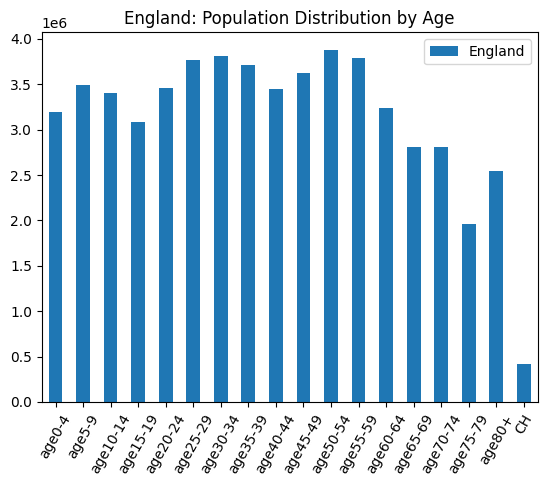

In [4]:
EN_pop = pd.read_csv('./BEEPmbp-COVID-19-analysis/COVID 19 England/Data_England_AS/population.csv')
EN_pop = EN_pop.T.iloc[1:].rename(columns={0:'England'})

EN_pop.plot.bar()
plt.xticks(rotation=60)
plt.title('England: Population Distribution by Age')

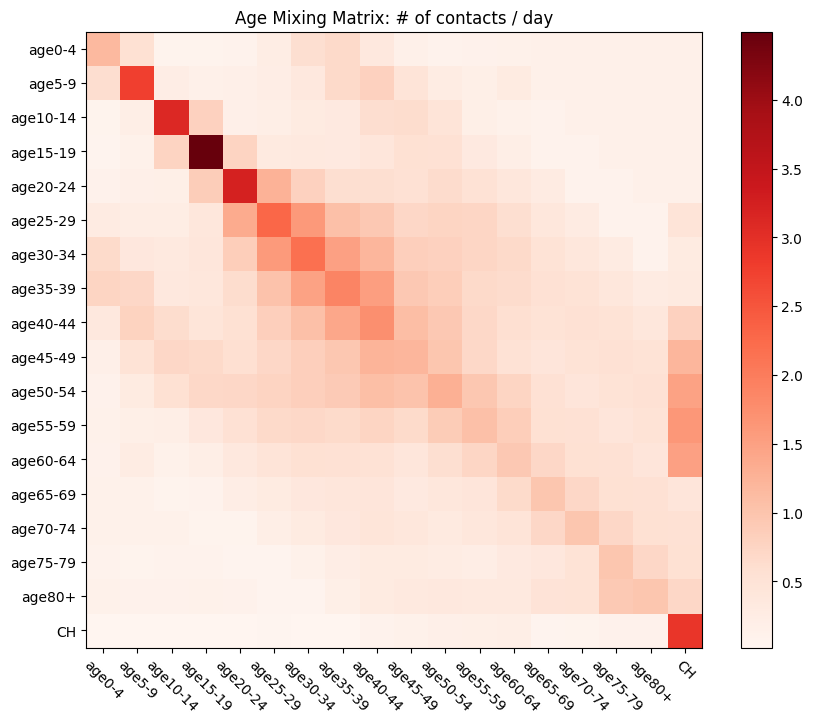

In [5]:
EN_contact_matrix = pd.read_csv('./BEEPmbp-COVID-19-analysis/COVID 19 England/Data_England_AS/age_mixing_matrix.csv', header=None) #, columns=EN_pop.index, index=EN_pop.index)
#EN_contact_matrix = EN_contact_matrix.shift(1)
#EN_contact_matrix.iloc[0] = EN_contact_matrix.columns
#EN_contact_matrix = EN_contact_matrix.astype(float)
EN_contact_matrix.columns = EN_pop.index
EN_contact_matrix = EN_contact_matrix.set_index(EN_pop.index)

plt.figure(figsize=(10, 8))
plt.imshow(EN_contact_matrix.values, cmap='Reds')
plt.xticks(range(len(EN_contact_matrix.columns)), EN_contact_matrix.columns, rotation=-45)
plt.yticks(range(len(EN_contact_matrix.columns)), EN_contact_matrix.columns)#, rotation=-45)
plt.title('Age Mixing Matrix: # of contacts / day')
plt.colorbar()

Text(0.5, 1.0, '$\\beta \\cdot M_{ij}$ ')

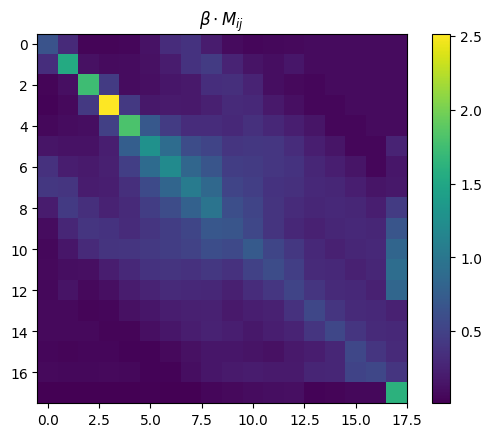

In [8]:
lambda_ = get_lambda(EN_contact_matrix.values, EN_pop.values.T[0])
Gamma = 1/14
Beta_ = 5*Gamma/lambda_
Beta = Beta_*EN_contact_matrix.values

I0 = 1
a = SIR1((EN_pop.values.T[0] -I0).tolist(), [I0]*EN_pop.shape[0], [0]*EN_pop.shape[0], Beta.tolist(), Gamma, 0.01, EN_pop.index.tolist())
a.run(200)

plt.imshow(Beta.tolist())
plt.colorbar()
plt.title('$\\beta \\cdot M_{ij}$ ')

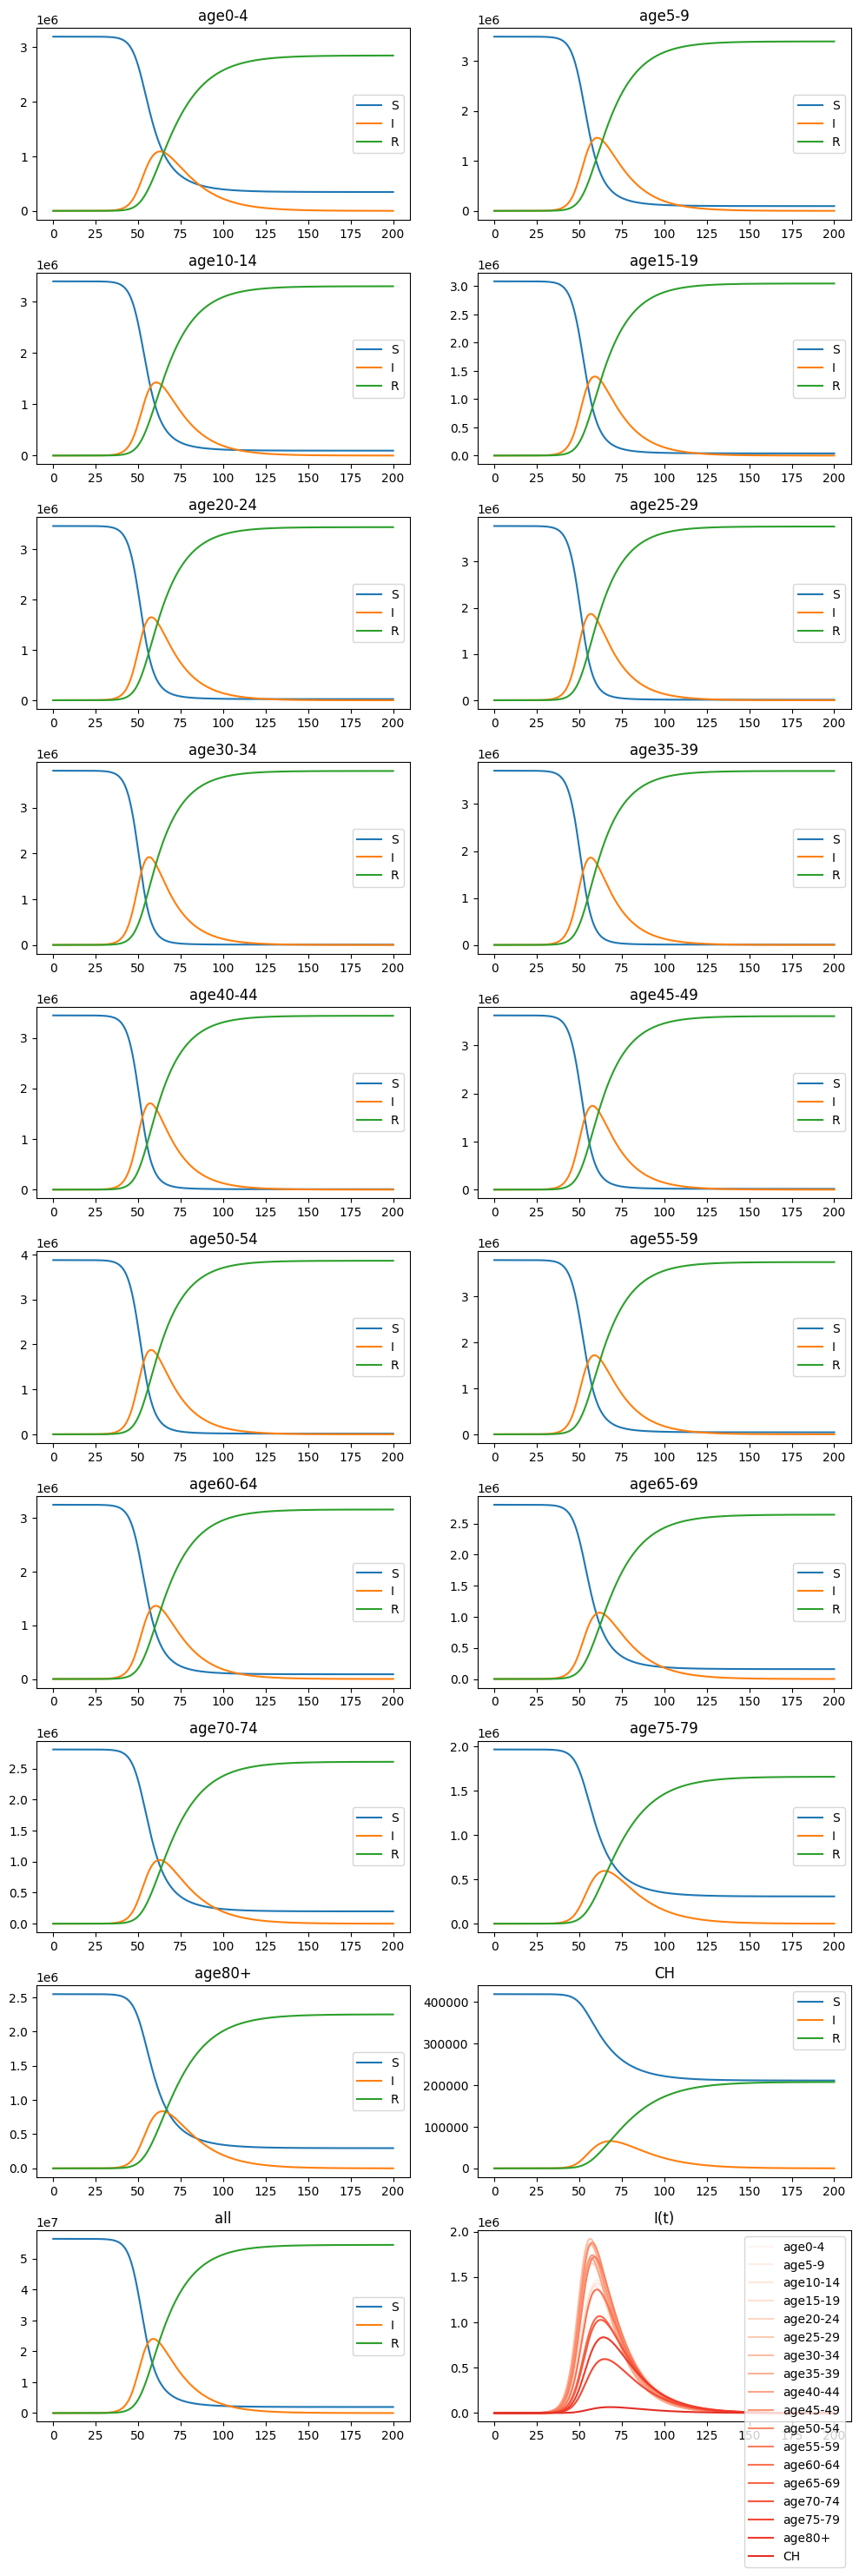

In [9]:
items = list(range(a.n_groups)) + [None]
fig, axes = plt.subplots(len(items)//2 + 1, 2, figsize = (10, 30))

count=0
for i in range(len(items)//2 + 1):
    for j in [0, 1]:#range(1):
        try:
            if count >= a.n_groups:
                count = None
            axes[i, j].plot(a.time_vector, a.S_timecourse(count), label='S')
            axes[i, j].plot(a.time_vector, a.I_timecourse(count), label='I')
            axes[i, j].plot(a.time_vector, a.R_timecourse(count), label='R')
            axes[i, j].legend()
            axes[i, j].set_title(a.group_labels[count] if count is not None else 'all')
            if count is not None:
                count +=1
        except:
            break
            
for k in range(a.n_groups):
    axes[-1, -1].plot(a.time_vector, a.I_timecourse(k), label=a.group_labels[k], color=plt.cm.Reds(10*k))
    axes[-1, -1].set_title('I(t)')
    axes[-1, -1].legend()
        
fig.show()
fig.tight_layout()